# Load required libraries

In [36]:
import math
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing,metrics,linear_model
from sklearn.model_selection import cross_val_score,cross_val_predict,train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBRegressor
import scipy.stats as st
from tqdm import tqdm_notebook as tqdm

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout , LSTM , Bidirectional 

## Load the dataset: We use the hourly data for the DL approach since we our model will need more datapoints.

In [37]:
df = pd.read_csv('../dataset/hour.csv')

## Data exploration

In [38]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [39]:
df.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

## Preprocessing

In [40]:
df.rename(columns={'instant':'rec_id','dteday':'datetime','yr':'year','mnth':'month','weathersit':'weather_condition',
                       'hum':'humidity','cnt':'total_count'},inplace=True)

In [41]:
df['datetime'] = pd.to_datetime(df['datetime'])

df['datetime']=pd.to_datetime(df.datetime)

df['season']= df.season.astype('category')
df['hr'] = df.hr.astype('category')
df['year']=df.year.astype('category')
df['month']=df.month.astype('category')
df['holiday']=df.holiday.astype('category')
df['weekday']=df.weekday.astype('category')
df['workingday']=df.workingday.astype('category')
df['weather_condition']=df.weather_condition.astype('category')

In [42]:
df.drop('rec_id', axis=1, inplace=True)

## Remove highly correlated (redundant) features

(<Figure size 720x720 with 2 Axes>, <AxesSubplot:>)

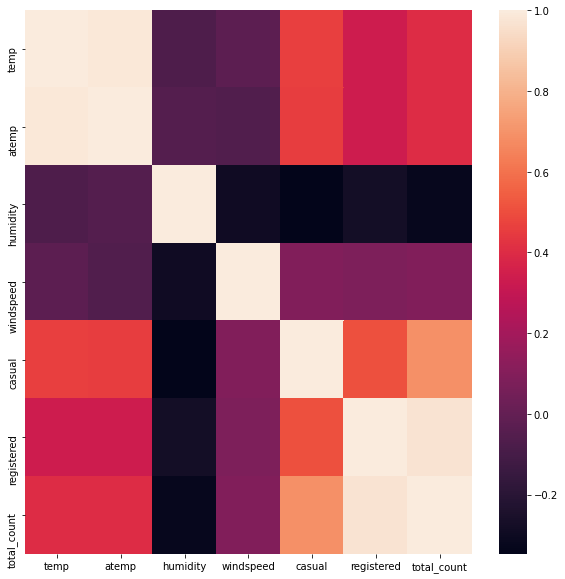

In [43]:
# Check for correlation
plt.figure(figsize = (10,10)), sns.heatmap(df.corr())

(<Figure size 720x720 with 2 Axes>, <AxesSubplot:>)

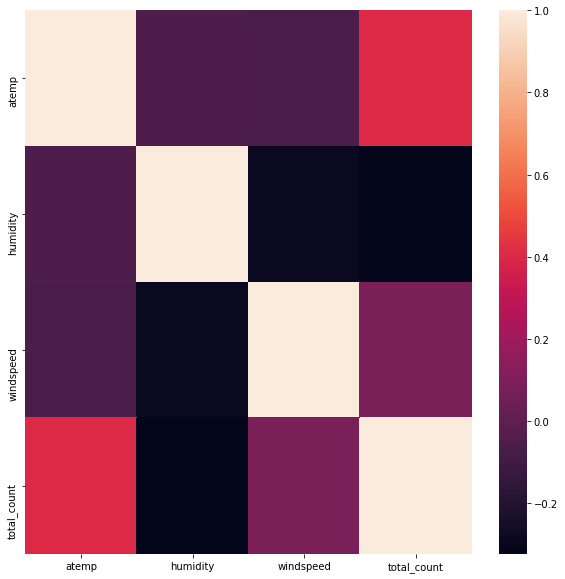

In [44]:
# Remove highly correlated values

df.drop(['casual','registered','temp', 'datetime'], axis = 1, inplace = True)

# Verify

plt.figure(figsize = (10,10)), sns.heatmap(df.corr())

## Outlier analysis of numerical variables

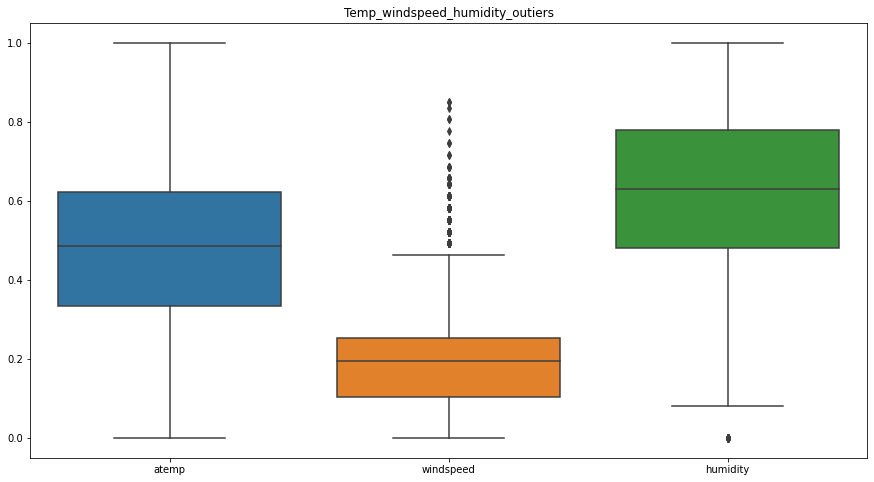

In [45]:
# Outlier analysis of numerical variables

# Temp, windspeed, humidity

fig,ax=plt.subplots(figsize=(15,8))
#Box plot for Temp_windspeed_humidity_outliers
sns.boxplot(data=df[['atemp','windspeed','humidity']])
ax.set_title('Temp_windspeed_humidity_outiers')
plt.show()

In [46]:
# Impute the outlier values


#create dataframe for outliers
wind_hum=pd.DataFrame(df,columns=['windspeed','humidity'])
 #Cnames for outliers                     
cnames=['windspeed','humidity']       
                      
for i in cnames:
    q75,q25=np.percentile(wind_hum.loc[:,i],[75,25]) # Divide data into 75%quantile and 25%quantile.
    iqr=q75-q25 #Inter quantile range
    min=q25-(iqr*1.5) #inner fence
    max=q75+(iqr*1.5) #outer fence
    wind_hum.loc[wind_hum.loc[:,i]<min,:i]=np.nan  #Replace with NA
    wind_hum.loc[wind_hum.loc[:,i]>max,:i]=np.nan  #Replace with NA
    
#Imputating the outliers by mean Imputation
wind_hum['windspeed']=wind_hum['windspeed'].fillna(wind_hum['windspeed'].mean())
wind_hum['humidity']=wind_hum['humidity'].fillna(wind_hum['humidity'].mean())

#Replacing the imputated windspeed
df['windspeed']= df['windspeed'].replace(wind_hum['windspeed'])
#Replacing the imputated humidity
df['humidity']= df['humidity'].replace(wind_hum['humidity'])
df.head(5)

,season,year,month,hr,holiday,weekday,workingday,weather_condition,atemp,humidity,windspeed,total_count
0,1,0,1,0,0,6,0,1,0.2879,0.81,0.0,16
1,1,0,1,1,0,6,0,1,0.2727,0.80,0.0,40
2,1,0,1,2,0,6,0,1,0.2727,0.80,0.0,32
3,1,0,1,3,0,6,0,1,0.2879,0.75,0.0,13
4,1,0,1,4,0,6,0,1,0.2879,0.75,0.0,1


## Encode the dataset

In [47]:
#Create a new dataset for train attributes
all_attributes = df[['season','month','hr', 'year','weekday','holiday','workingday','weather_condition','humidity','atemp','windspeed', 'total_count']]

#categorical attributes
cat_attributes=['season','holiday','hr','workingday','weather_condition','year']

#numerical attributes
num_attributes=['atemp','windspeed','humidity','month','weekday']

In [48]:
data = pd.get_dummies(all_attributes,columns=cat_attributes)
print('Shape of transfomed dataframe::', data.shape)
data.head(5)

Shape of transfomed dataframe:: (17379, 44)


,month,weekday,humidity,atemp,windspeed,total_count,season_1,season_2,season_3,season_4,...,hr_22,hr_23,workingday_0,workingday_1,weather_condition_1,weather_condition_2,weather_condition_3,weather_condition_4,year_0,year_1
0,1,6,0.81,0.2879,0.0,16,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0
1,1,6,0.80,0.2727,0.0,40,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0
2,1,6,0.80,0.2727,0.0,32,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0
3,1,6,0.75,0.2879,0.0,13,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0
4,1,6,0.75,0.2879,0.0,1,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0


## Normalization of dataset: We normalize the dataset to make our NN model fit better

In [49]:
train,test = train_test_split(data,test_size=0.1,random_state=0)

print(train.shape)
print(test.shape)

(15641, 44)
(1738, 44)


In [50]:
scaler  = MinMaxScaler()

num_colu = ['atemp', 'humidity', 'windspeed']
trans_1 = scaler.fit(train[num_colu].to_numpy())
train.loc[:,num_colu] = trans_1.transform(train[num_colu].to_numpy())
test.loc[:,num_colu] = trans_1.transform(test[num_colu].to_numpy())

cnt_scaler = MinMaxScaler()
trans_2 = cnt_scaler.fit(train[["total_count"]])
train["total_count"] = trans_2.transform(train[["total_count"]])
test["total_count"] = trans_2.transform(test[["total_count"]])

## Scaling: Add the time step in the dataset to make it compatible with the NN model

In [51]:
tqdm().pandas()

def prepare_data(X,y,time_steps=1):
    Xs = []
    Ys = []
    for i in tqdm(range(len(X) - time_steps)):
        a = X.iloc[i:(i + time_steps)].to_numpy()
        Xs.append(a)
        Ys.append(y.iloc[i+time_steps])
    return np.array(Xs),np.array(Ys)    

steps=24 # Each hour in a day
X_train , y_train = prepare_data(train,train.total_count,time_steps=steps)
X_test , y_test = prepare_data(test,test.total_count,time_steps=steps)

In [52]:
print("X_train : {}\nX_test : {}\ny_train : {}\ny_test: {}".format(X_train.shape,X_test.shape,y_train.shape,y_test.shape))

X_train : (15617, 24, 44)
X_test : (1714, 24, 44)
y_train : (15617,)
y_test: (1714,)


### Train a Bi-LSTM model on the last 600 days (hourly) and test it against 70 days (hourly)

In [53]:
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=False, input_shape=(X_train.shape[1],X_train.shape[2]))))
model.add(Dropout(0.2))
model.add(Dense(1,activation="sigmoid"))
model.compile(optimizer="adam",loss="mse")

In [54]:
prepared_model = model.fit(X_train,y_train,batch_size=32,epochs=100,validation_data=(X_test,y_test))

Epoch 1/100
489/489 [==============================] - 6s 13ms/step - loss: 0.0373 - val_loss: 0.0336
Epoch 2/100
489/489 [==============================] - 6s 11ms/step - loss: 0.0353 - val_loss: 0.0348
Epoch 3/100
489/489 [==============================] - 5s 11ms/step - loss: 0.0351 - val_loss: 0.0337
Epoch 4/100
489/489 [==============================] - 5s 11ms/step - loss: 0.0349 - val_loss: 0.0337
Epoch 5/100
489/489 [==============================] - 6s 13ms/step - loss: 0.0349 - val_loss: 0.0336
Epoch 6/100
489/489 [==============================] - 5s 11ms/step - loss: 0.0347 - val_loss: 0.0337
Epoch 7/100
489/489 [==============================] - 5s 11ms/step - loss: 0.0347 - val_loss: 0.0342
Epoch 8/100
489/489 [==============================] - 5s 11ms/step - loss: 0.0347 - val_loss: 0.0343
Epoch 9/100
489/489 [==============================] - 5s 11ms/step - loss: 0.0345 - val_loss: 0.0338
Epoch 10/100
489/489 [==============================] - 6s 12ms/step - loss: 0.034

489/489 [==============================] - 5s 10ms/step - loss: 0.0061 - val_loss: 0.0544
Epoch 81/100
489/489 [==============================] - 5s 10ms/step - loss: 0.0063 - val_loss: 0.0561
Epoch 82/100
489/489 [==============================] - 5s 10ms/step - loss: 0.0061 - val_loss: 0.0562
Epoch 83/100
489/489 [==============================] - 5s 10ms/step - loss: 0.0061 - val_loss: 0.0549
Epoch 84/100
489/489 [==============================] - 5s 11ms/step - loss: 0.0060 - val_loss: 0.0554
Epoch 85/100
489/489 [==============================] - 5s 10ms/step - loss: 0.0058 - val_loss: 0.0544
Epoch 86/100
489/489 [==============================] - 5s 10ms/step - loss: 0.0057 - val_loss: 0.0559
Epoch 87/100
489/489 [==============================] - 5s 10ms/step - loss: 0.0058 - val_loss: 0.0547
Epoch 88/100
489/489 [==============================] - 5s 10ms/step - loss: 0.0055 - val_loss: 0.0552
Epoch 89/100
489/489 [==============================] - 5s 10ms/step - loss: 0.0054 - 

## Prediction: Last 70 days

In [55]:
pred = model.predict(X_test)

y_test_inv = cnt_scaler.inverse_transform(y_test.reshape(-1,1))
pred_inv = cnt_scaler.inverse_transform(pred)

y_test_actual = cnt_scaler.inverse_transform(y_test.reshape(-1,1))
y_test_pred = cnt_scaler.inverse_transform(pred)

arr_1 = np.array(y_test_actual)
arr_2 = np.array(y_test_pred)

actual = pd.DataFrame(data=arr_1.flatten(),columns=["actual"])
predicted = pd.DataFrame(data=arr_2.flatten(),columns = ["predicted"])

final = pd.concat([actual,predicted],axis=1)

In [56]:
print(pred_inv.reshape(-1))

[100.202805 154.44649  511.81177  ... 141.2473   192.97298  234.78279 ]


In [57]:
final.head()

,actual,predicted
0,431.0,100.202805
1,33.0,154.446487
2,505.0,511.811768
3,267.0,161.901657
4,243.0,179.837006


### Performace of the model

In [58]:
rmse = np.sqrt(mean_squared_error(final.actual,final.predicted)) 
mae=metrics.mean_absolute_error(final.actual,final.predicted)
#r2 = r2_score(final.actual,final.predicted) 
print("rmse is : {}\nmae is : {}".format(rmse,mae))

rmse is : 228.224513954759
mae is : 173.09200750404366


### Save the model

In [59]:
model_json = model.to_json()
with open("nn_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("nn_model.h5")

### Plot observed vs. predicted for the last 70 days

Text(0.5, 0, 'Hours')

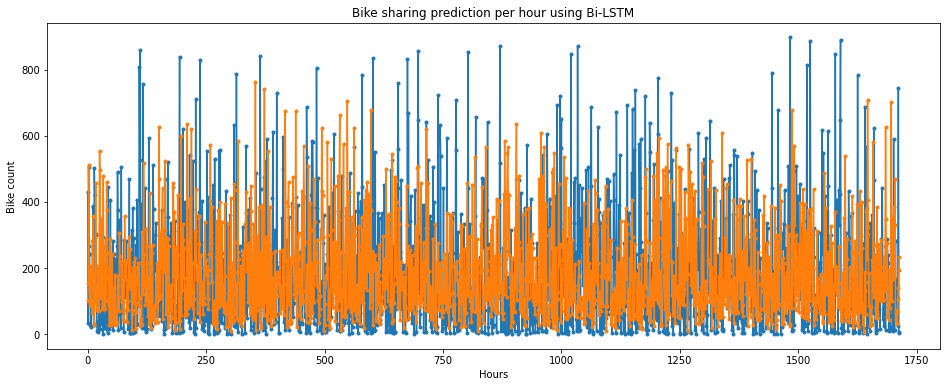

In [60]:
plt.figure(figsize=(16,6))
plt.plot(y_test_inv.flatten(), marker=".", label="actual")
plt.plot(pred_inv.flatten(), marker=".", label="prediction")
plt.title('Bike sharing prediction per hour using Bi-LSTM')
plt.ylabel('Bike count')
plt.xlabel('Hours')